In [1]:
import pandas as pd
import numpy as np
import mlflow.pytorch
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Step 1: Load and Explore the Data
df = pd.read_csv('./breast-cancer.csv')
df.info()
print(df.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

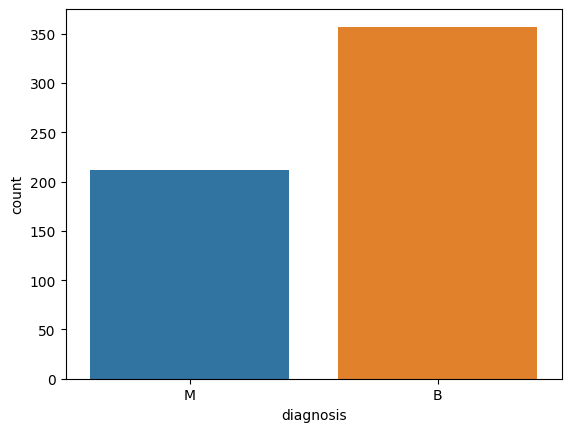

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


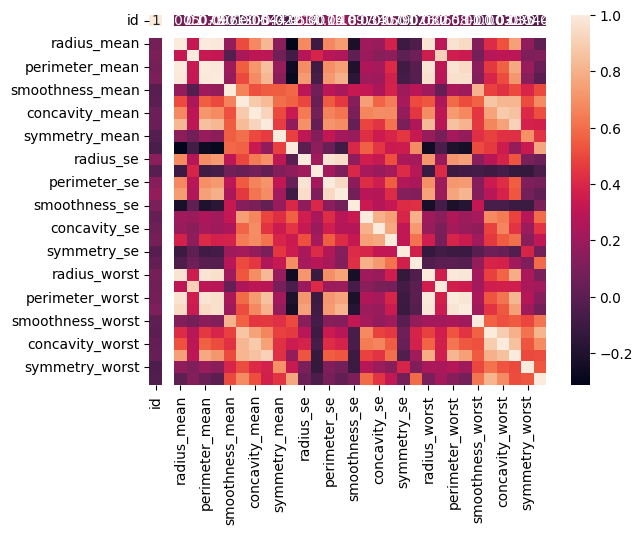

In [3]:
# Step 2: Exploratory Data Analysis (EDA)
sns.countplot(x='diagnosis', data=df)
plt.show()

df['diagnosis'] = df['diagnosis'].apply(lambda x: 0 if x == 'benign' else 1)
sns.heatmap(df.corr(), annot=True)
plt.show()

In [4]:
# Step 3: Train-Test Split
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [5]:
# Step 4: Data Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Step 5: Train a PyTorch Model
class BreastCancerModel(nn.Module):
    def __init__(self):
        super(BreastCancerModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 30)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(30, 15)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(15, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = BreastCancerModel()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [25]:
# Step 6: Train the Model and Track Loss with MLflow
mlflow.pytorch.autolog()

with mlflow.start_run():
    num_epochs = 600
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(X_test, dtype=torch.float32)
            val_targets = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [1/600], Loss: 0.6193, Val Loss: 0.6206
Epoch [2/600], Loss: 0.6190, Val Loss: 0.6202
Epoch [3/600], Loss: 0.6176, Val Loss: 0.6198
Epoch [4/600], Loss: 0.6189, Val Loss: 0.6194
Epoch [5/600], Loss: 0.6169, Val Loss: 0.6190
Epoch [6/600], Loss: 0.6160, Val Loss: 0.6186
Epoch [7/600], Loss: 0.6164, Val Loss: 0.6182
Epoch [8/600], Loss: 0.6159, Val Loss: 0.6179
Epoch [9/600], Loss: 0.6152, Val Loss: 0.6175
Epoch [10/600], Loss: 0.6138, Val Loss: 0.6171
Epoch [11/600], Loss: 0.6149, Val Loss: 0.6167
Epoch [12/600], Loss: 0.6157, Val Loss: 0.6163
Epoch [13/600], Loss: 0.6128, Val Loss: 0.6159
Epoch [14/600], Loss: 0.6148, Val Loss: 0.6155
Epoch [15/600], Loss: 0.6126, Val Loss: 0.6151
Epoch [16/600], Loss: 0.6125, Val Loss: 0.6148
Epoch [17/600], Loss: 0.6120, Val Loss: 0.6144
Epoch [18/600], Loss: 0.6130, Val Loss: 0.6140
Epoch [19/600], Loss: 0.6113, Val Loss: 0.6136
Epoch [20/600], Loss: 0.6113, Val Loss: 0.6132
Epoch [21/600], Loss: 0.6123, Val Loss: 0.6128
Epoch [22/600], Loss: 

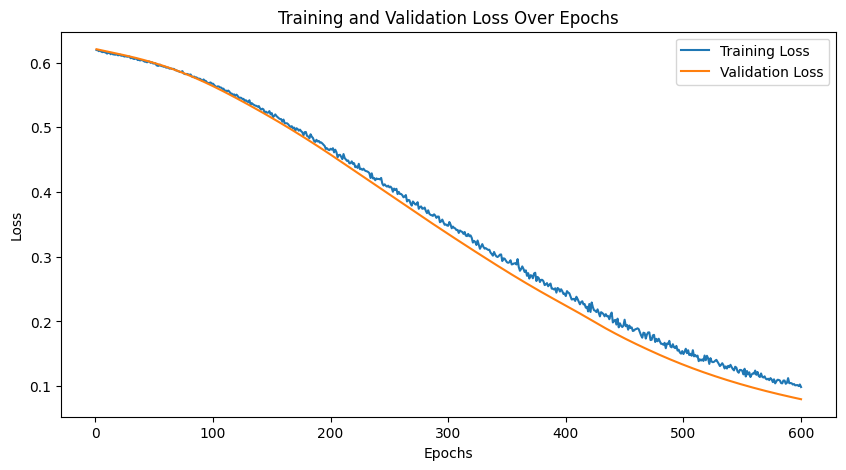

In [26]:
# Plot the Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [27]:
# Step 7: Model Evaluation
model.eval()
with torch.no_grad():
    val_inputs = torch.tensor(X_test, dtype=torch.float32)
    predictions = torch.sigmoid(model(val_inputs)).numpy()
    predictions_binary = [1 if p > 0.5 else 0 for p in predictions]

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions_binary))
print(confusion_matrix(y_test, predictions_binary))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       143

    accuracy                           1.00       143
   macro avg       1.00      1.00      1.00       143
weighted avg       1.00      1.00      1.00       143

[[143]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
